In [1]:
from ema_workbench import (
    Model,
    MultiprocessingEvaluator,
    SequentialEvaluator,
    ScalarOutcome,
    IntegerParameter,
    optimize,
    Scenario,
    Policy,
    save_results,
    load_results,
)
from ema_workbench.util import ema_logging

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [2]:
import copy
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

In [3]:
#results_v0 = pd.read_csv("directed search results/dike_model_policy_design.csv",index_col=0)
#results_v1 = pd.read_csv("directed search results/dike_model_policy_design_big_nfe.csv",index_col=0)
results_v0 = pd.read_csv("directed search results/seed results/dike_model_policy_design_big_nfe.csv",index_col=0)

In [4]:
model, steps = get_model_for_problem_formulation(2)

### Re-evaluating Candidate Solutions under different scenarios

- Filtering policies based on hard constraints.
    - Expected Number of Deaths < 0.001
    - At least one Rfr project i.e. sum(Rfr) >=1
    - Expected Annual Damage < 0.01

In [5]:
#Double RfR filter
projects = set()
for col in results_v0.columns:
    if '_RfR' in col:

        projects.add(col.split('_')[0])
# Initialize a boolean mask with False indicating rows to keep
rows_to_delete = pd.Series([False] * len(results_v0))

# Iterate over each project and update the mask
for project in projects:

    # Get columns for the current project
    project_cols = [col for col in results_v0.columns if col.startswith(project)]
    # Update the mask for rows where the sum across the project's columns is greater than 1
    rows_to_delete |= results_v0[project_cols].sum(axis=1) > 1

# Remove these rows from the DataFrame
df_cleaned = results_v0[~rows_to_delete]
results_v0 = df_cleaned
results_v0

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Total Investment Costs
0,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,2.843996e+06,1.522105e+08,0.0,108.955096,0.000183,1.522106e+08
1,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,1.091955e+07,1.483075e+08,0.0,438.444906,0.000977,1.483080e+08
3,0,0,0,0,0,0,1,0,0,0,...,0,4,0,0,3.873201e+06,1.449808e+08,30700000.0,176.645474,0.000247,1.756810e+08
5,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,0.000000e+00,1.557268e+08,0.0,0.000000,0.000000,1.557268e+08
7,0,0,0,0,0,0,1,0,0,0,...,0,4,0,0,9.862925e+06,1.429506e+08,30700000.0,465.165670,0.000939,1.736511e+08
8,0,0,0,0,0,0,1,0,0,0,...,0,4,0,0,0.000000e+00,1.490962e+08,30700000.0,0.000000,0.000000,1.797962e+08
9,0,0,0,0,0,0,1,0,0,0,...,0,3,0,0,7.755517e+06,1.430766e+08,30700000.0,313.725509,0.000678,1.737769e+08
10,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,8.617838e+06,1.503062e+08,0.0,346.115931,0.000770,1.503066e+08
14,0,0,0,0,0,0,1,0,0,0,...,0,4,0,0,6.591638e+06,1.440720e+08,30700000.0,267.038812,0.000573,1.747722e+08
15,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,5.553718e+05,1.533318e+08,0.0,22.339010,0.000049,1.533318e+08


In [6]:
logical_1 = results_v0['Expected Number of Deaths']<0.001
results_v0['RfR_agg']=results_v0.iloc[:,0:15].agg(['sum'],axis="columns")
logical_2 = results_v0['RfR_agg']>=0
logical_3 = results_v0['Expected Annual Damage']<0.01

In [7]:
#logical_11 = results_v1['Expected Number of Deaths']<0.001
#results_v1['RfR_agg']=results_v1.iloc[:,0:15].agg(['sum'],axis="columns")
#logical_21 = results_v1['RfR_agg']>=1
#logical_31 = results_v1['Expected Annual Damage']<0.01

In [8]:
#policies = pd.concat([results_v0[logical_1 & logical_2 & logical_3],results_v1[logical_11 & logical_21 & logical_31]])
#policies.to_csv("Filtered Policies - to be tested for robustness.csv")
policies = results_v0[logical_1 & logical_2 & logical_3]
policies.to_csv("Filtered Policies - to be tested for robustness.csv")
policies.head()

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Total Investment Costs,RfR_agg
5,0,0,0,0,0,0,0,0,0,0,...,4,0,0,0.0,1.557268e+08,0.0,0.0,0.0,1.557268e+08,0
8,0,0,0,0,0,0,1,0,0,0,...,4,0,0,0.0,1.490962e+08,30700000.0,0.0,0.0,1.797962e+08,1
16,0,0,0,0,0,0,1,0,0,0,...,3,0,0,0.0,1.410464e+08,151900000.0,0.0,0.0,2.929464e+08,2


In [9]:
#policies = pd.concat([results_v0[logical_1 & logical_2 & logical_3],results_v1[logical_11 & logical_21 & logical_31]])
policies = policies.drop([o.name for o in model.outcomes], axis=1)
policies = policies.drop(columns=['RfR_agg'])
policies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, 5 to 16
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   0_RfR 0             3 non-null      int64
 1   0_RfR 1             3 non-null      int64
 2   0_RfR 2             3 non-null      int64
 3   1_RfR 0             3 non-null      int64
 4   1_RfR 1             3 non-null      int64
 5   1_RfR 2             3 non-null      int64
 6   2_RfR 0             3 non-null      int64
 7   2_RfR 1             3 non-null      int64
 8   2_RfR 2             3 non-null      int64
 9   3_RfR 0             3 non-null      int64
 10  3_RfR 1             3 non-null      int64
 11  3_RfR 2             3 non-null      int64
 12  4_RfR 0             3 non-null      int64
 13  4_RfR 1             3 non-null      int64
 14  4_RfR 2             3 non-null      int64
 15  EWS_DaysToThreat    3 non-null      int64
 16  A.1_DikeIncrease 0  3 non-null      int64
 17  A.1_D

In [10]:
policies_to_evaluate = []
for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

In [11]:
len(policies_to_evaluate)

3

In [12]:
n_scenarios=100

In [13]:
print(f"Evaluating {len(policies_to_evaluate)} policies across {n_scenarios} scenarios")

Evaluating 3 policies across 100 scenarios


In [14]:
import random
random.seed(123)

In [15]:
#with MultiprocessingEvaluator(model) as evaluator:
with SequentialEvaluator(model) as evaluator:
    scenario_results = evaluator.perform_experiments(n_scenarios,policies_to_evaluate)

100%|████████████████████████████████████████| 300/300 [05:01<00:00,  1.01s/it]


In [16]:
save_results(scenario_results, "directed search results/policy_robustness_1000_scenarios.tar.gz")

### Calculating Signal to Noise Ratio

In [17]:
scenario_results=load_results("directed search results/policy_robustness_1000_scenarios.tar.gz")

In [18]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [19]:
experiments, outcomes = scenario_results
np.unique(experiments['policy'])

array([ 5,  8, 16], dtype=int64)

In [20]:
experiments, outcomes = scenario_results
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Total Investment Costs
5,5.896567e+17,4.641021,0.0,1.722604e+08,0.004335,2.327735e+12
8,6.542097e+17,4.443414,0.0,3.071758e+08,0.006453,3.786244e+12
16,6.251788e+17,0.000000,0.0,2.670951e+08,0.005633,5.711366e+12


In [21]:
ooi=scores.columns.tolist()
ooi

['Expected Annual Damage',
 'Dike Investment Costs',
 'RfR Investment Costs',
 'Evacuation Costs',
 'Expected Number of Deaths',
 'Total Investment Costs']

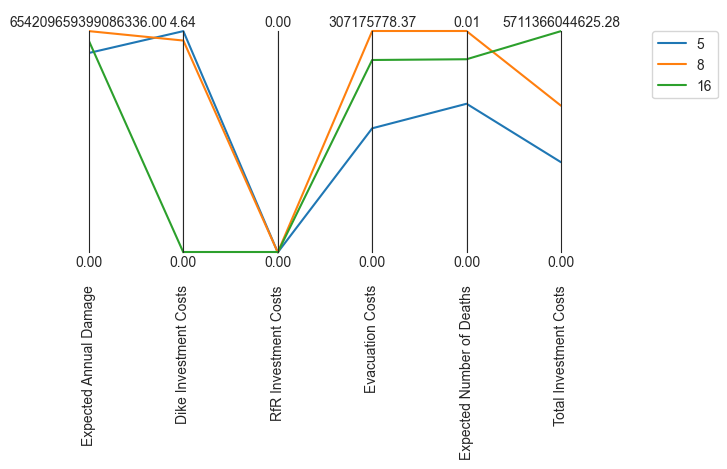

In [22]:
from ema_workbench.analysis import parcoords


colors = sns.color_palette()
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ooi] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()

plt.savefig("directed search results/parcoord for SNR plot.png",bbox_inches='tight')
plt.show()


## Calculating regret

In [23]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [24]:
experiments, outcomes = scenario_results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.min(axis=1).values[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()
    

In [25]:
data

policy,5,8,16
scenario,,,
0,1.557572e+08,1.798266e+08,2.929797e+08
1,1.557481e+08,1.798293e+08,2.929768e+08
2,1.557607e+08,1.798290e+08,2.929801e+08
3,1.557269e+08,1.797968e+08,2.929464e+08
4,1.557614e+08,1.798369e+08,2.929843e+08
...,...,...,...
95,1.557387e+08,1.798101e+08,2.929621e+08
96,1.557391e+08,1.798088e+08,2.929566e+08
97,1.557293e+08,1.797984e+08,2.929488e+08


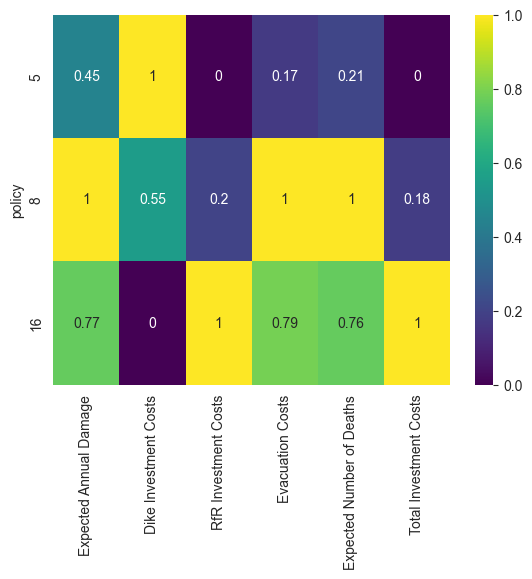

In [26]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.savefig("directed search results/heatmap for max regret plot.png", bbox_inches='tight')
plt.show()

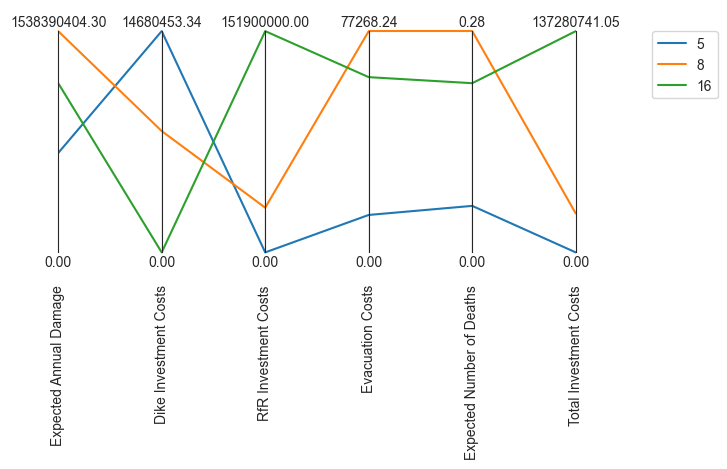

,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths,Total Investment Costs
policy,,,,,,
5,6.908406e+08,1.468045e+07,0.0,13078.263544,0.057906,0.000000e+00
8,1.538390e+09,8.049874e+06,30700000.0,77268.239537,0.275404,2.414669e+07
16,1.176912e+09,0.000000e+00,151900000.0,61194.386650,0.210605,1.372807e+08


In [27]:

colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, ooi] = 0

paraxes = parcoords.ParallelAxes(limits,fontsize=10)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()

plt.savefig("directed search results/parcoord for regret plot.png",bbox_inches='tight')
plt.show()
data

In [28]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

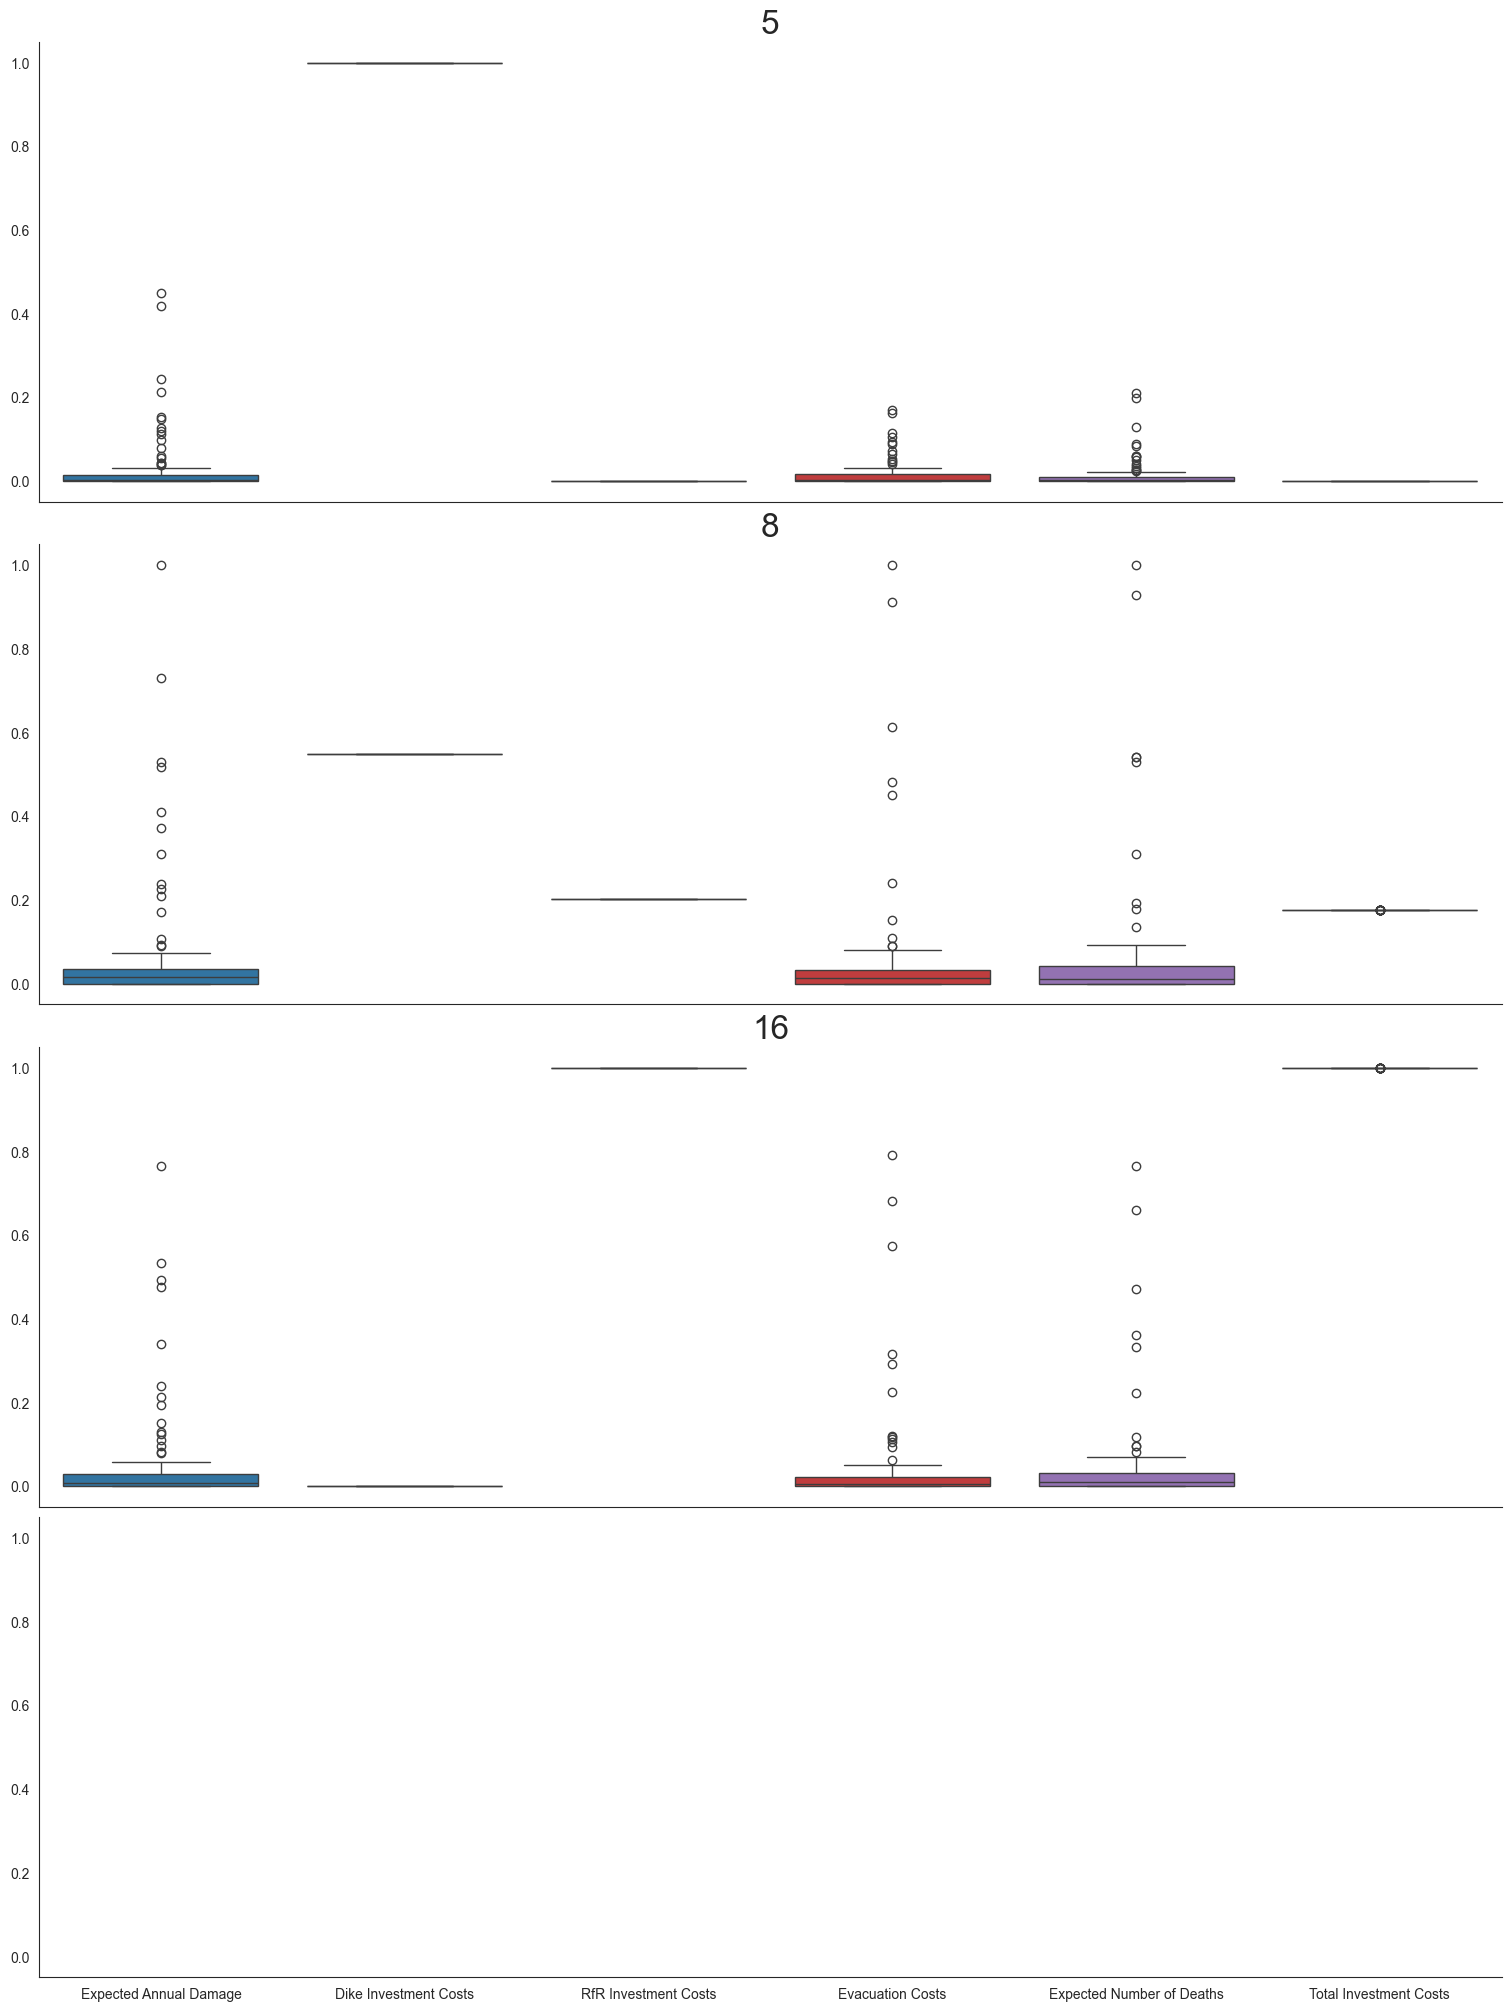

In [29]:
# this generates a 2 plots with a shared y and x axis
fig, axes = plt.subplots( nrows=4, figsize=(15,20), 
                         sharey=True, sharex=True,constrained_layout=True)
#axes.flatten()

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 


# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy),fontsize=24)


plt.savefig("directed search results/boxplot for regret.png")
plt.show()

## Scenario Discovery
Under which conditions do these policies result in poor performance?

In [30]:
experiments, outcomes = scenario_results

In [31]:
from ema_workbench.analysis import prim

x = experiments.drop(labels=[l.name for l in model.levers], axis=1)
#x=x.drop(labels=['scenario','model','policy'],axis=1)
#y = outcomes['Expected Annual Damage'] > 0.1
y = (outcomes['Expected Number of Deaths']) > 0 & (outcomes['Expected Annual Damage'] > 0.1)


In [32]:
x.columns

Index(['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2', 'num_events', 'scenario', 'policy', 'model'],
      dtype='object')

In [33]:
prim_alg = prim.Prim(x, y, threshold=0.8,peel_alpha=0.1)
box = prim_alg.find_box()

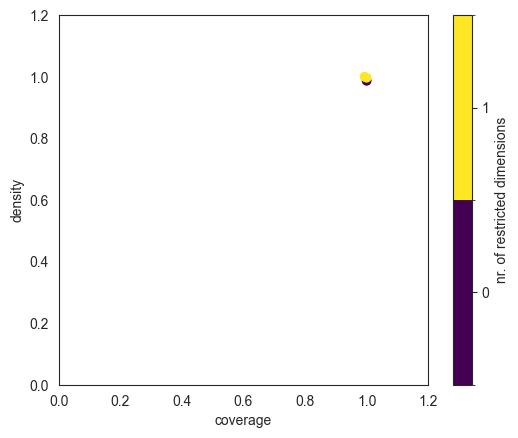

In [34]:
import matplotlib.pyplot as plt
box.show_tradeoff(annotated=False)
plt.savefig('prim_policies/PRIM_coverage_density_tradeoff_not_annotated.png',bbox_inches='tight')
plt.show()


In [35]:
point = 4
box.inspect(point)

IndexError: single positional indexer is out-of-bounds

In [ ]:
point = 4
box.inspect(point,style='graph')
plt.savefig('prim_inspection_4.png',bbox_inches='tight')

In [ ]:
resample_b4=box.resample(point)
resample_b4.to_csv("prim_policies/resampling_box_point4.csv")

In [ ]:
df_box0=prim_alg.stats_to_dataframe()
df_box_for_box0=prim_alg.boxes_to_dataframe()

In [ ]:
df_box0.to_csv('prim_policies/PRIM_box0.csv')

In [ ]:
df_box_for_box0.to_csv('prim_policies/PRIM_box0_stats.csv')

In [ ]:
box.inspect_tradeoff()
#plt.savefig('prim_policies/trade_off_plots.png')

In [ ]:
box.inspect(4,style='graph')

In [ ]:
box.inspect(5,style='graph')

In [ ]:
box1 = prim_alg.find_box()

In [ ]:
box1.show_tradeoff()

In [ ]:
prim_df=prim_alg.stats_to_dataframe()
prim_box_df=prim_alg.boxes_to_dataframe()

In [ ]:
prim_df

In [ ]:
prim_box_df

In [ ]:
box2 = prim_alg.find_box()
box2.show_tradeoff()

In [ ]:
prim_df_box2=prim_alg.stats_to_dataframe()
prim_box_df_box2=prim_alg.boxes_to_dataframe()

In [ ]:
prim_df_box2

In [ ]:
prim_box_df_box2